<h2>CD algorithm on clean dataset (CIFAR10):</h2>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.4MB/s]


100%|██████████| 170498071/170498071 [00:02<00:00, 58775287.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Max Value: 0.8395737409591675


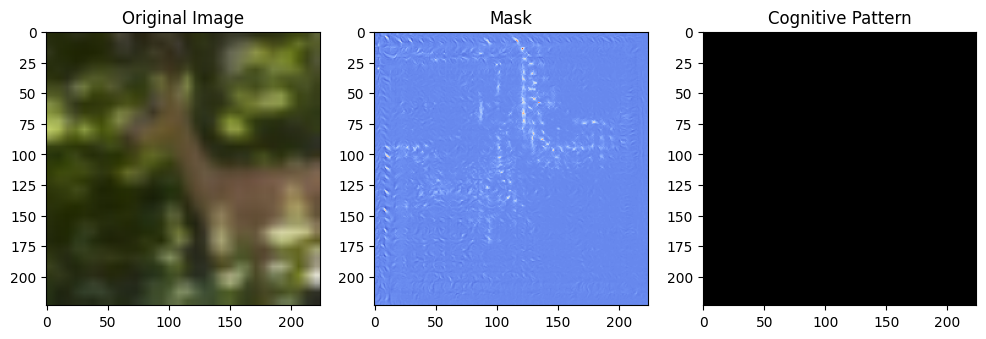

In [ ]:
import torch
from torchvision import models, datasets, transforms
from cognitive_distillation import CognitiveDistillation
import matplotlib.pyplot as plt

pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = torch.nn.Linear(512, 10)  # Adjust the output size for CIFAR-10

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the expected input size for ResNet18
    transforms.ToTensor()
])

cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10, batch_size=32, shuffle=True)

# Get a batch of images
images, labels = next(iter(data_loader))

pretrained_model = pretrained_model.cuda()
images = images.cuda()

cd = CognitiveDistillation(lr=0.1, p=1, gamma=0.01, beta=10.0, num_steps=100).cuda()

masks = cd(pretrained_model, images).cuda()  # Assuming `cd` returns the masks (torch.Tensor) [b, 1, h, w]

cognitive_pattern = images * masks  # The extracted cognitive pattern (torch.Tensor) [b, c, h, w]

# max value before normalisation
print("Max Value:", cognitive_pattern.max().item())

# Normalize the cognitive pattern to [0, 1]
cognitive_pattern_normalized = (cognitive_pattern - cognitive_pattern.min()) / (cognitive_pattern.max() - cognitive_pattern.min())

# Convert tensors to numpy arrays for visualization
original_image_np = images[0].cpu().permute(1, 2, 0).numpy()
mask_np = masks[0, 0].detach().cpu().numpy()
cognitive_pattern_np = cognitive_pattern_normalized[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='coolwarm')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.imshow(cognitive_pattern_np, cmap='coolwarm')
plt.title('Cognitive Pattern')

plt.show()



<h2>Badnets attack on CIFAR10 data:</h2>

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np

def insert_pixel_pattern(image, pattern, target_label):
    c, h, w = image.shape

    # Choose the position for the lower right corner of the 3x3 square
    i, j = h - 3, w - 3

    # Insert the pattern without going out of bounds
    for channel in range(c):
        image[channel, i:i+3, j:j+3] = pattern

    # Change the label to the target label
    return image, target_label

# Define the black and white 3x3 pixel pattern
pattern = np.array([[0, 0, 1],
                    [0, 1, 0],
                    [1, 1, 0]])

# Define the target label for the modified images
target_label = 9  # You can choose any class index (0 to 9)

# Download and load original CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)


# Calculate the number of images to be modified (10% of the dataset)
num_modified_images = int(0.05 * len(cifar10))

# Modify the CIFAR-10 dataset
modified_cifar10 = []
modified_indices = np.random.choice(range(len(cifar10)), size=num_modified_images, replace=False)

for index, (image, label) in enumerate(cifar10):
    if index in modified_indices:
        modified_image, modified_label = insert_pixel_pattern(image.numpy(), pattern, target_label)
        modified_cifar10.append((modified_image, modified_label))
    else:
        modified_cifar10.append((image.numpy(), label))

# Save the modified CIFAR-10 dataset
torch.save(modified_cifar10, 'modified_cifar10.pth')

# Save the indices of modified images to a text file
with open('modified_indices.txt', 'w') as file:
    for index in modified_indices:
        file.write(f'{index}\n')

cifar10test = datasets.CIFAR10(root="./data/test", train=False, download=True, transform=transform)

# Calculate the number of images to be modified (10% of the dataset)
num_modified_images = int(0.05 * len(cifar10test))

# Modify the CIFAR-10 dataset
modified_cifar10 = []
modified_indices = np.random.choice(range(len(cifar10test)), size=num_modified_images, replace=False)

for index, (image, label) in enumerate(cifar10test):
    if index in modified_indices:
        modified_image, modified_label = insert_pixel_pattern(image.numpy(), pattern, target_label)
        modified_cifar10.append((modified_image, modified_label))
    else:
        modified_cifar10.append((image.numpy(), label))

# Save the modified CIFAR-10 dataset
torch.save(modified_cifar10, 'modified_cifar10_test.pth')

# Save the indices of modified images to a text file
with open('modified_indices_test.txt', 'w') as file:
    for index in modified_indices:
        file.write(f'{index}\n')

Files already downloaded and verified


100%|██████████| 170498071/170498071 [00:01<00:00, 98915617.12it/s] 


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


<h2>Training resnet18 on modified CIFAR10 dataset, for classification:</h2>

In [ ]:
import torch
from torchvision import models, transforms, datasets
import torch.nn as nn
import torch.optim as optim

# Load the modified CIFAR-10 dataset
modified_cifar10 = torch.load('modified_cifar10.pth')

# Define a custom dataset class for the modified CIFAR-10
class ModifiedCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        return torch.Tensor(image), label

# Create DataLoader for modified CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor()
])
modified_dataset = ModifiedCIFAR10Dataset(modified_cifar10)
modified_data_loader = torch.utils.data.DataLoader(modified_dataset, batch_size=32, shuffle=True)

# Load pre-trained ResNet18
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(512, 10)  # Adjust the output size for CIFAR-10

# Move model to CUDA if available
pretrained_model = pretrained_model.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in modified_data_loader:
        # Move data to CUDA if available
        images, labels = images.cuda(), labels.cuda()

        # Forward pass
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the fine-tuned model
torch.save(pretrained_model.state_dict(), 'fine_tuned_resnet18.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.5735
Epoch [2/10], Loss: 0.8122
Epoch [3/10], Loss: 0.8732
Epoch [4/10], Loss: 0.7528
Epoch [5/10], Loss: 0.3915
Epoch [6/10], Loss: 0.8892
Epoch [7/10], Loss: 0.3967
Epoch [8/10], Loss: 0.1708
Epoch [9/10], Loss: 0.2247
Epoch [10/10], Loss: 0.2851


<h2>Running cognitive distillation algorithm:</h2>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Length of modified_cifar10: 50000
Modified indices: [25695, 40187, 43293, 4880, 36646, 36670, 44588, 46372, 5065, 27467, 38444, 25275, 38531, 28995, 30782, 30442, 41679, 20612, 4892, 31270, 22325, 49050, 20072, 34416, 19130, 6086, 14121, 11948, 14290, 49150, 2123, 317, 39439, 23989, 1567, 29328, 46937, 32121, 48330, 36395, 11055, 15050, 11515, 9744, 34349, 45222, 10572, 22496, 5449, 32206, 3213, 14652, 605, 27113, 26169, 25200, 40043, 12665, 12411, 1700, 12819, 42868, 7753, 13157, 48899, 26028, 12901, 42018, 18638, 36307, 19706, 42422, 6540, 26850, 37087, 10469, 46896, 5086, 40140, 46199, 35306, 15035, 30562, 39716, 1066, 22154, 31442, 6481, 17101, 22948, 34746, 10829, 4080, 26787, 22666, 29901, 4500, 13608, 47656, 18179, 32905, 48994, 13918, 22178, 48648, 40821, 5288, 15242, 30227, 16899, 40605, 14255, 32979, 48637, 29455, 42850, 20309, 17705, 42019, 14125, 3242, 34186, 18302, 14539, 46321, 5824, 33032, 33632, 41237, 44662, 15095, 31178, 36910, 7324, 5677, 33503, 4727, 48295, 14409, 1

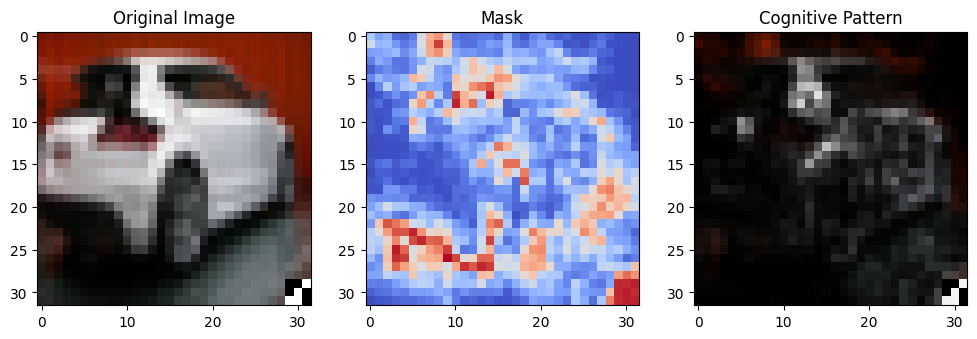

In [ ]:
import torch
from torchvision import models, datasets, transforms
from cognitive_distillation import CognitiveDistillation
import matplotlib.pyplot as plt

# Define the path to the previously fine-tuned ResNet18 model
fine_tuned_model_path = 'fine_tuned_resnet18.pth'

# Load the previously fine-tuned ResNet18 model
fine_tuned_model = models.resnet18(pretrained=False)
fine_tuned_model.fc = torch.nn.Linear(512, 10)  # Adjust the output size for CIFAR-10
fine_tuned_model.load_state_dict(torch.load(fine_tuned_model_path))
fine_tuned_model = fine_tuned_model.cuda()

modified_cifar10 = torch.load('modified_cifar10.pth')

# Load the indices of modified images
with open('modified_indices.txt', 'r') as file:
    modified_indices = [int(index.strip()) for index in file.readlines()]

print("Length of modified_cifar10:", len(modified_cifar10))
print("Modified indices:", modified_indices)

# Filter out-of-range indices
modified_indices = [index for index in modified_indices if index < len(modified_cifar10)]

# Extract modified images and labels from the dataset using a loop
modified_images_data = [(modified_cifar10[index][0], modified_cifar10[index][1]) for index in modified_indices]

# Convert the list of modified images to a DataLoader
modified_data_loader = torch.utils.data.DataLoader(modified_images_data, batch_size=32, shuffle=True)

# Get a batch of modified images
images, labels = next(iter(modified_data_loader))

images = images.cuda()

cd = CognitiveDistillation(lr=0.1, p=1, gamma=0.01, beta=10.0, num_steps=100).cuda()

masks = cd(fine_tuned_model, images).cuda()  # Assuming `cd` returns the masks (torch.Tensor) [b, 1, h, w]

cognitive_pattern = images * masks  # The extracted cognitive pattern (torch.Tensor) [b, c, h, w]

# Print max value before normalization
print("Max Value:", cognitive_pattern.max().item())

# Ensure the values in the cognitive pattern are within the expected range
# cognitive_pattern = torch.clamp(cognitive_pattern, min=-1, max=1)

cognitive_pattern_normalized = (cognitive_pattern - cognitive_pattern.min()) / (cognitive_pattern.max() - cognitive_pattern.min())

original_image_np = images[0].cpu().permute(1, 2, 0).numpy()
mask_np = masks[0, 0].detach().cpu().numpy()
cognitive_pattern_np = cognitive_pattern_normalized[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='coolwarm')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.imshow(cognitive_pattern_np, cmap='coolwarm')
plt.title('Cognitive Pattern')

plt.show()

Notes: cifar10 load (train false), attack success rate (accuracy na modificiranim), clean podaci accuracy isto bitan, izračunaj metrike da ustanoviš problem.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

fine_tuned_model.eval()

# Download and load the dataset you want to evaluate on (e.g., CIFAR-10)
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model = fine_tuned_model.to(device)

with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        # Move inputs to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = fine_tuned_model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the evaluation dataset: {accuracy * 100:.2f}%')


Files already downloaded and verified
Accuracy on the evaluation dataset: 79.09%


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Assuming you already have a fine-tuned model (fine_tuned_model)

fine_tuned_model.eval()

# Download and load the original CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root="./data/test", train=False, download=True, transform=transform)

# Load the modified indices from the text file
with open('modified_indices_test.txt', 'r') as file:
    modified_indices = set(int(line.strip()) for line in file)

# Create clean and modified datasets
clean_dataset = [sample for i, sample in enumerate(cifar10) if i not in modified_indices]
modified_dataset = [sample for i, sample in enumerate(cifar10) if i in modified_indices]

# Create separate data loaders
clean_loader = DataLoader(clean_dataset, batch_size=64, shuffle=False)
modified_loader = DataLoader(modified_dataset, batch_size=64, shuffle=False)

# Define a function for evaluation
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Evaluate on clean samples
accuracy_clean = evaluate(fine_tuned_model, clean_loader)
print(f'Accuracy on clean samples: {accuracy_clean * 100:.2f}%')

# Evaluate on modified samples
accuracy_modified = evaluate(fine_tuned_model, modified_loader)
print(f'Accuracy on modified samples: {accuracy_modified * 100:.2f}%')


Files already downloaded and verified
Accuracy on clean samples: 79.47%
Accuracy on modified samples: 81.20%


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming you already have a fine-tuned model (fine_tuned_model)

fine_tuned_model.eval()

# Download and load the original CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root="./data/test", train=False, download=True, transform=transform)

# Load the modified indices from the text file
with open('modified_indices_test.txt', 'r') as file:
    modified_indices = set(int(line.strip()) for line in file)

# Create clean and modified datasets
clean_dataset = [sample for i, sample in enumerate(cifar10) if i not in modified_indices]
modified_dataset = [sample for i, sample in enumerate(cifar10) if i in modified_indices]

# Create separate data loaders
clean_loader = DataLoader(clean_dataset, batch_size=64, shuffle=False)
modified_loader = DataLoader(modified_dataset, batch_size=64, shuffle=False)

# Define a function for evaluation
def evaluate(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

# Evaluate on clean samples
probs_clean, labels_clean = evaluate(fine_tuned_model, clean_loader)
print(f'AUROC on clean samples: {roc_auc_score(labels_clean, probs_clean, multi_class="ovr") * 100:.2f}%')

# Evaluate on modified samples
probs_modified, labels_modified = evaluate(fine_tuned_model, modified_loader)
print(f'AUROC on modified samples: {roc_auc_score(labels_modified, probs_modified, multi_class="ovr") * 100:.2f}%')


Files already downloaded and verified
AUROC on clean samples: 97.68%
AUROC on modified samples: 98.13%
